## Libs



In [40]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import shapiro, levene, ttest_ind, mannwhitneyu
from wordcloud import WordCloud
import nltk
import re
nltk.download('stopwords')
nltk.download('rslp')
from nltk.corpus import stopwords
from nltk.stem import RSLPStemmer
stop_words = set(stopwords.words('portuguese'))
stemmer = RSLPStemmer()
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.combine import SMOTEENN, SMOTETomek
from xgboost import XGBClassifier
from collections import Counter

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package rslp to /root/nltk_data...
[nltk_data]   Package rslp is already up-to-date!


In [2]:
# Função para carregar arquivos JSON
def carregar_json(caminho):
    with open(caminho, 'r', encoding='utf-8') as f:
        return json.load(f)

# Carregar os arquivos
jobs = carregar_json('vagas.json')
prospects = carregar_json('prospects.json')
applicants = carregar_json('applicants.json')

# Converter jobs.json em DataFrame
df_jobs = pd.DataFrame.from_dict(jobs, orient='index').reset_index().rename(columns={'index': 'job_id'})

# Converter applicants.json em DataFrame
df_applicants = pd.DataFrame.from_dict(applicants, orient='index').reset_index().rename(columns={'index': 'applicant_id'})

# Tratar estrutura variada do prospects.json
lista_prospects = []

for job_id, value in prospects.items():
    if isinstance(value, list):
        for candidato in value:
            if isinstance(candidato, dict):
                lista_prospects.append({'job_id': job_id, **candidato})
    elif isinstance(value, dict) and 'prospects' in value:
        for candidato in value['prospects']:
            if isinstance(candidato, dict):
                lista_prospects.append({'job_id': job_id, **candidato})
    else:
        print(f"[AVISO] Estrutura inesperada na vaga {job_id}: {type(value)}")

df_prospects = pd.DataFrame(lista_prospects)

In [3]:
# Unir os dados: prospects + applicants + jobs
df_merge = df_prospects.merge(df_applicants, left_on='codigo', right_on='applicant_id', how='left')
df_merge = df_merge.merge(df_jobs, on='job_id', how='left')
print("Formato final da base:", df_merge.shape)
display(df_merge.head())


Formato final da base: (53759, 19)


,job_id,nome,codigo,situacao_candidado,data_candidatura,ultima_atualizacao,comentario,recrutador,applicant_id,infos_basicas,informacoes_pessoais,informacoes_profissionais,formacao_e_idiomas,cargo_atual,cv_pt,cv_en,informacoes_basicas,perfil_vaga,beneficios
0,4530,José Vieira,25632,Encaminhado ao Requisitante,25-03-2021,25-03-2021,"Encaminhado para - PJ R$ 72,00/hora",Ana Lívia Moreira,25632,"{'telefone_recado': '', 'telefone': '(21) 9348...",{'data_aceite': 'Cadastro anterior ao registro...,"{'titulo_profissional': '', 'area_atuacao': ''...","{'nivel_academico': '', 'nivel_ingles': '', 'n...",{},\ndados pessoais\nestado civil: casado\nidade:...,,"{'data_requicisao': '10-03-2021', 'limite_espe...","{'pais': 'Brasil', 'estado': 'Rio de Janeiro',...","{'valor_venda': '-', 'valor_compra_1': 'R$', '..."
1,4530,Srta. Isabela Cavalcante,25529,Encaminhado ao Requisitante,22-03-2021,23-03-2021,"encaminhado para - R$ 6.000,00 – CLT Full , n...",Ana Lívia Moreira,25529,"{'telefone_recado': '', 'telefone': '(21) 9426...",{'data_aceite': 'Cadastro anterior ao registro...,{'titulo_profissional': 'ANALISTA DE REDES E T...,{'nivel_academico': 'Ensino Superior Completo'...,{},"solteiro, 47 anos\n\nestrada meringuava, nº 17...",,"{'data_requicisao': '10-03-2021', 'limite_espe...","{'pais': 'Brasil', 'estado': 'Rio de Janeiro',...","{'valor_venda': '-', 'valor_compra_1': 'R$', '..."
2,4531,Sra. Yasmin Fernandes,25364,Contratado pela Decision,17-03-2021,12-04-2021,Data de Inicio: 12/04/2021,Juliana Cassiano,25364,"{'telefone_recado': '', 'telefone': '(21) 9633...",{'data_aceite': 'Cadastro anterior ao registro...,{'titulo_profissional': 'Liderança / Desenvolv...,{'nivel_academico': 'Ensino Superior Completo'...,{},\n\nárea de atuação: lider de consultoria / ge...,,"{'data_requicisao': '10-03-2021', 'limite_espe...","{'pais': 'Brasil', 'estado': 'São Paulo', 'cid...","{'valor_venda': '-', 'valor_compra_1': 'hora',..."
3,4531,Alexia Barbosa,25360,Encaminhado ao Requisitante,17-03-2021,17-03-2021,,Juliana Cassiano,25360,"{'telefone_recado': '', 'telefone': '(11) 9774...",{'data_aceite': 'Cadastro anterior ao registro...,"{'titulo_profissional': '', 'area_atuacao': ''...","{'nivel_academico': '', 'nivel_ingles': '', 'n...",{},informações pessoais\n estado civil: casado\n...,,"{'data_requicisao': '10-03-2021', 'limite_espe...","{'pais': 'Brasil', 'estado': 'São Paulo', 'cid...","{'valor_venda': '-', 'valor_compra_1': 'hora',..."
4,4533,Arthur Almeida,26338,Contratado pela Decision,29-04-2021,18-05-2021,,Stella Vieira,26338,"{'telefone_recado': '', 'telefone': '(31) 9270...","{'data_aceite': '25/11/2022 11:04', 'nome': 'A...","{'titulo_profissional': '', 'area_atuacao': ''...","{'nivel_academico': '', 'nivel_ingles': '', 'n...",{},"solteiro, brasileiro, 21/06/1987\nhabilitação ...",,"{'data_requicisao': '11-03-2021', 'limite_espe...","{'pais': 'Brasil', 'estado': 'São Paulo', 'cid...","{'valor_venda': '207,00 -', 'valor_compra_1': ..."


In [4]:
df_merge['situacao_candidado'].unique()

array(['Encaminhado ao Requisitante', 'Contratado pela Decision',
       'Desistiu', 'Documentação PJ', 'Não Aprovado pelo Cliente',
       'Prospect', 'Não Aprovado pelo RH', 'Aprovado',
       'Não Aprovado pelo Requisitante', 'Inscrito', 'Entrevista Técnica',
       'Em avaliação pelo RH', 'Contratado como Hunting',
       'Desistiu da Contratação', 'Entrevista com Cliente',
       'Documentação CLT', 'Recusado', 'Documentação Cooperado',
       'Sem interesse nesta vaga', 'Encaminhar Proposta',
       'Proposta Aceita'], dtype=object)

In [5]:
df_merge['situacao_candidado'].value_counts()

,count
situacao_candidado,
Prospect,20021
Encaminhado ao Requisitante,16122
Inscrito,3980
Não Aprovado pelo Cliente,3492
Contratado pela Decision,2758
Desistiu,2349
Não Aprovado pelo RH,1765
Não Aprovado pelo Requisitante,765
Entrevista Técnica,579


In [6]:
# Categorias que podem indicar sucesso na contratação, mas aí tem que ver
categorias_contratado = [
    'Contratado pela Decision',
    'Contratado como Hunting',
    'Proposta Aceita'
]

# Criando a variável alvo
df_merge['target_contratado'] = df_merge['situacao_candidado'].apply(lambda x: 1 if x in categorias_contratado else 0)

#distribuição
df_merge['target_contratado'].value_counts(normalize=True).rename(index={1: 'Contratado', 0: 'Não contratado'})

,proportion
target_contratado,
Não contratado,0.944474
Contratado,0.055526


In [7]:
# Verificar colunas com mais de 50% de valores nulos
df_merge.isnull().mean().sort_values(ascending=False).head(20)

,0
applicant_id,0.161164
infos_basicas,0.161164
informacoes_pessoais,0.161164
informacoes_profissionais,0.161164
cv_en,0.161164
cv_pt,0.161164
cargo_atual,0.161164
formacao_e_idiomas,0.161164
informacoes_basicas,0.000446
perfil_vaga,0.000446


In [8]:
# Preencher nulos com string vazia
df_modelo = df_merge.copy()
colunas_texto = ['formacao_e_idiomas', 'cargo_atual', 'perfil_vaga', 'beneficios','informacoes_profissionais', 'infos_basicas']
df_modelo[colunas_texto] = df_modelo[colunas_texto].fillna('')

# Criar coluna de texto consolidado
df_modelo['texto_geral'] = df_modelo[colunas_texto].astype(str).agg(' '.join, axis=1)

In [9]:
# Função de pré-processamento final (stopwords + stem)
def clean_stopwords_stem(texto):
    if not isinstance(texto, str): return ''
    tokens = re.sub(r'[\W\d_]+', ' ', texto.lower()).split()
    return ' '.join([stemmer.stem(t) for t in tokens if t not in stop_words and len(t) > 2])

# Combinar múltiplas colunas em uma
colunas_texto = ['cv_pt', 'informacoes_profissionais', 'formacao_e_idiomas', 'perfil_vaga', 'beneficios']
df_modelo['texto_completo'] = df_modelo[colunas_texto].fillna('').astype(str).agg(' '.join, axis=1)
df_modelo['texto_completo_limpo'] = df_modelo['texto_completo'].apply(clean_stopwords_stem)

# Separar treino/teste
X_texto = df_modelo['texto_completo_limpo'].fillna('')
y = df_modelo['target_contratado']
X_train_txt, X_test_txt, y_train, y_test = train_test_split(X_texto, y, stratify=y, test_size=0.3, random_state=1995)

# Vetorizar texto
vectorizer = TfidfVectorizer(max_features=3000)
X_train_vect = vectorizer.fit_transform(X_train_txt)
X_test_vect = vectorizer.transform(X_test_txt)

# Análise Exploratória e Feature Engineering

In [10]:
#df_merge.to_csv('df_jason.csv', sep=';',index=False)

In [11]:
# colunas disponíveis
print("Colunas disponíveis:")
print(df_modelo.columns.tolist())

Colunas disponíveis:
['job_id', 'nome', 'codigo', 'situacao_candidado', 'data_candidatura', 'ultima_atualizacao', 'comentario', 'recrutador', 'applicant_id', 'infos_basicas', 'informacoes_pessoais', 'informacoes_profissionais', 'formacao_e_idiomas', 'cargo_atual', 'cv_pt', 'cv_en', 'informacoes_basicas', 'perfil_vaga', 'beneficios', 'target_contratado', 'texto_geral', 'texto_completo', 'texto_completo_limpo']


In [12]:
# tipos de dados
print("\nTipos de dados:")
print(df_merge.dtypes)


Tipos de dados:
job_id                       object
nome                         object
codigo                       object
situacao_candidado           object
data_candidatura             object
ultima_atualizacao           object
comentario                   object
recrutador                   object
applicant_id                 object
infos_basicas                object
informacoes_pessoais         object
informacoes_profissionais    object
formacao_e_idiomas           object
cargo_atual                  object
cv_pt                        object
cv_en                        object
informacoes_basicas          object
perfil_vaga                  object
beneficios                   object
target_contratado             int64
dtype: object


In [13]:
# porcentagem de valores nulos
print("\nPorcentagem de valores nulos:")
print((df_modelo.isnull().mean() * 100).sort_values(ascending=False).head(20))


Porcentagem de valores nulos:
cv_pt                        16.116371
informacoes_pessoais         16.116371
applicant_id                 16.116371
cv_en                        16.116371
informacoes_basicas           0.044644
nome                          0.000000
job_id                        0.000000
comentario                    0.000000
ultima_atualizacao            0.000000
data_candidatura              0.000000
situacao_candidado            0.000000
codigo                        0.000000
informacoes_profissionais     0.000000
infos_basicas                 0.000000
recrutador                    0.000000
cargo_atual                   0.000000
formacao_e_idiomas            0.000000
perfil_vaga                   0.000000
beneficios                    0.000000
target_contratado             0.000000
dtype: float64


## Frequência de palavras mais comuns

In [14]:
# Tokenizar todos os textos
todos_tokens = ' '.join(df_modelo['texto_completo_limpo']).split()

# Contar frequência
frequencia = Counter(todos_tokens).most_common(30)

pd.DataFrame(frequencia, columns=['termo', 'frequencia'])

,termo,frequencia
0,projet,412389
1,nivel,396710
2,sap,380530
3,desenvolv,336935
4,sistem,276738
5,profiss,217922
6,and,205500
7,process,200141
8,consult,199952
9,val,189900


## Wordclouds por classe

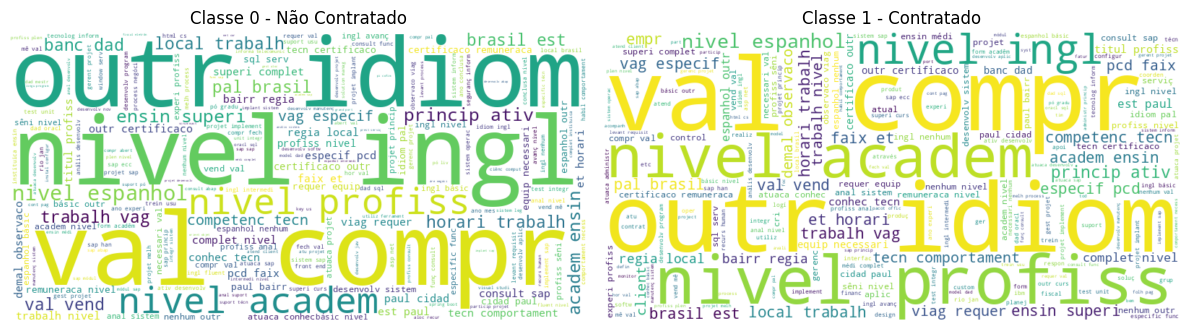

In [15]:
# Separar textos por classe
texto_negativo = ' '.join(df_modelo[df_modelo['target_contratado'] == 0]['texto_completo_limpo'])
texto_positivo = ' '.join(df_modelo[df_modelo['target_contratado'] == 1]['texto_completo_limpo'])

# WordCloud - classe 0
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.title('Classe 0 - Não Contratado')
wc0 = WordCloud(width=800, height=400, background_color='white').generate(texto_negativo)
plt.imshow(wc0, interpolation='bilinear')
plt.axis('off')

# WordCloud - classe 1
plt.subplot(1, 2, 2)
plt.title('Classe 1 - Contratado')
wc1 = WordCloud(width=800, height=400, background_color='white').generate(texto_positivo)
plt.imshow(wc1, interpolation='bilinear')
plt.axis('off')
plt.tight_layout()
plt.show()

## Comparação de termos por classe

In [16]:
# Criar contadores separados
tokens_0 = ' '.join(df_modelo[df_modelo['target_contratado'] == 0]['texto_completo_limpo']).split()
tokens_1 = ' '.join(df_modelo[df_modelo['target_contratado'] == 1]['texto_completo_limpo']).split()

freq_0 = Counter(tokens_0)
freq_1 = Counter(tokens_1)

# Criar DataFrame para comparação
df_comp = pd.DataFrame({
    'frequencia_0': pd.Series(freq_0),
    'frequencia_1': pd.Series(freq_1)
}).fillna(0).astype(int)

# Calcular proporção relativa (ou diferença absoluta)
df_comp['proporcao_1'] = df_comp['frequencia_1'] / (df_comp['frequencia_1'] + df_comp['frequencia_0'])

# Mostrar termos mais associados à classe 1
df_comp.sort_values(by='proporcao_1', ascending=False).head(20)

,frequencia_0,frequencia_1,proporcao_1
aacsb,0,1,1.0
aaau,0,1,1.0
ﬂavioprud,0,2,1.0
embragen,0,1,1.0
embrom,0,1,1.0
swm,0,4,1.0
sysbibl,0,1,1.0
appinterfac,0,1,1.0
sweeping,0,1,1.0
sweeg,0,1,1.0


## Distribuição por nivel_academico vs. target

In [17]:
df_modelo['nivel_academico'] = df_modelo['formacao_e_idiomas'].apply(lambda x: eval(x).get('nivel_academico', '') if isinstance(x, str) and 'nivel_academico' in x else '')

pd.crosstab(df_modelo['nivel_academico'], df_modelo['target_contratado'], normalize='index') \
  .sort_values(by=1, ascending=False) \
  .rename(columns={0: 'Não Contratado', 1: 'Contratado'}) \
  .style.background_gradient(cmap='Blues')


target_contratado,Não Contratado,Contratado
nivel_academico,,
,0.944474,0.055526


## Distribuição por nivel_ingles e nivel_espanhol

In [18]:
for idioma in ['nivel_ingles', 'nivel_espanhol']:
    df_modelo[idioma] = df_modelo['formacao_e_idiomas'].apply(lambda x: eval(x).get(idioma, '') if isinstance(x, str) and idioma in x else '')

    display(
        pd.crosstab(df_modelo[idioma], df_modelo['target_contratado'], normalize='index') \
        .sort_values(by=1, ascending=False) \
        .rename(columns={0: 'Não Contratado', 1: 'Contratado'}) \
        .style.set_caption(idioma).background_gradient(cmap='Purples')
    )


target_contratado,Não Contratado,Contratado
nivel_ingles,,
,0.944474,0.055526


target_contratado,Não Contratado,Contratado
nivel_espanhol,,
,0.944474,0.055526


##  Principais area_atuacao entre contratados

<Axes: title={'center': 'Área de atuação - Contratados'}, ylabel='area_atuacao'>

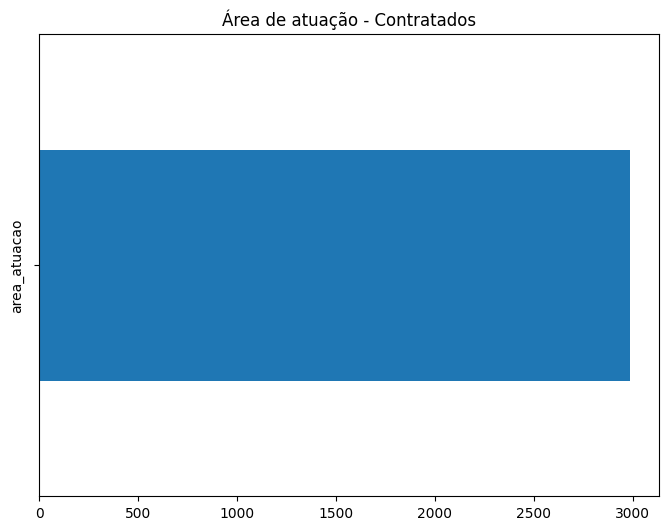

In [19]:
df_modelo['area_atuacao'] = df_modelo['informacoes_profissionais'].apply(lambda x: eval(x).get('area_atuacao', '') if isinstance(x, str) and 'area_atuacao' in x else '')

df_modelo[df_modelo['target_contratado'] == 1]['area_atuacao'].value_counts().head(20).plot(kind='barh', figsize=(8,6), title='Área de atuação - Contratados')


## Recrutadores que mais encaminham candidatos contratados


In [20]:
df_modelo['recrutador'] = df_modelo['recrutador'].fillna('Não informado')

pd.crosstab(df_modelo['recrutador'], df_modelo['target_contratado'], normalize='index') \
  .sort_values(by=1, ascending=False).head(15) \
  .rename(columns={0: 'Não Contratado', 1: 'Contratado'}) \
  .style.background_gradient(cmap='Reds')

target_contratado,Não Contratado,Contratado
recrutador,,
Hellena Dias,0.000000,1.000000
Melina Novaes,0.000000,1.000000
Vitória Pinto,0.000000,1.000000
Luna Dias,0.352113,0.647887
Dr. Luan Sá,0.414747,0.585253
Raquel Vieira,0.452381,0.547619
Sra. Joana Sousa,0.549383,0.450617
Paulo Peixoto,0.596983,0.403017
Carlos Eduardo Ribeiro,0.605825,0.394175


In [21]:
# Extrair campo se ele estiver como dicionário em string
df_modelo['nivel_academico'] = df_modelo['formacao_e_idiomas'].apply(
    lambda x: eval(x).get('nivel_academico', '') if isinstance(x, str) and 'nivel_academico' in x else ''
)

# tabela de proporções
tabela_academico = pd.crosstab(df_modelo['nivel_academico'], df_modelo['target_contratado'], normalize='index') \
    .rename(columns={0: 'Não Contratado', 1: 'Contratado'}) \
    .sort_values(by='Contratado', ascending=False)

#  mapa de calor
tabela_academico.style.background_gradient(cmap='Reds').set_caption("Proporção de Contratados por Nível Acadêmico")


target_contratado,Não Contratado,Contratado
nivel_academico,,
,0.944474,0.055526


## Proporção por titulo_profissional

In [22]:
df_modelo['titulo_profissional'] = df_modelo['informacoes_profissionais'].apply(
    lambda x: eval(x).get('titulo_profissional', '') if isinstance(x, str) and 'titulo_profissional' in x else ''
)

tabela_titulo = pd.crosstab(df_modelo['titulo_profissional'], df_modelo['target_contratado'], normalize='index') \
    .rename(columns={0: 'Não Contratado', 1: 'Contratado'}) \
    .sort_values(by='Contratado', ascending=False)

tabela_titulo.style.background_gradient(cmap='Reds').set_caption("Proporção de Contratados por Título Profissional")

target_contratado,Não Contratado,Contratado
titulo_profissional,,
,0.944474,0.055526


## Comparar proporção por cliente ou id da vaga

In [23]:
df_modelo['cliente'] = df_modelo['informacoes_basicas'].apply(
    lambda x: eval(x).get('cliente', '') if isinstance(x, str) and 'cliente' in x else ''
)

tabela_cliente = pd.crosstab(df_modelo['cliente'], df_modelo['target_contratado'], normalize='index') \
    .rename(columns={0: 'Não Contratado', 1: 'Contratado'}) \
    .sort_values(by='Contratado', ascending=False).head(15)

tabela_cliente.style.background_gradient(cmap='Reds').set_caption("Proporção de Contratados por Cliente")

target_contratado,Não Contratado,Contratado
cliente,,
,0.944474,0.055526


## Correlação entre idiomas e área de atuação

In [24]:
pd.crosstab(df_modelo['nivel_ingles'], df_modelo['area_atuacao']).style.background_gradient(cmap='Reds')

area_atuacao,
nivel_ingles,
,53759


## Número de palavras por CV

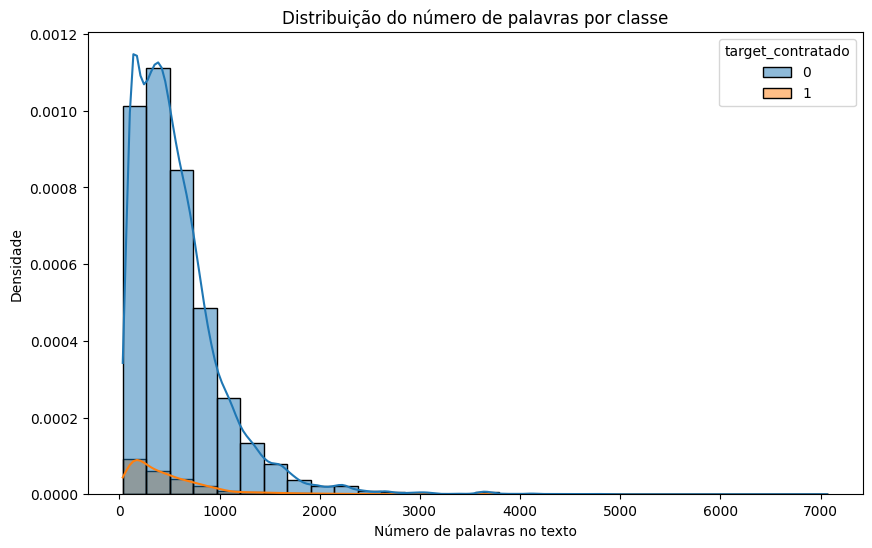

In [25]:
# Contar palavras no texto limpo
df_modelo['n_palavras'] = df_modelo['texto_completo_limpo'].apply(lambda x: len(x.split()))

# Comparar distribuições por classe

plt.figure(figsize=(10,6))
sns.histplot(data=df_modelo, x='n_palavras', hue='target_contratado', bins=30, kde=True, stat='density')
plt.title('Distribuição do número de palavras por classe')
plt.xlabel('Número de palavras no texto')
plt.ylabel('Densidade')
plt.show()

## Médias e medianas por classe



In [26]:
df_modelo.groupby('target_contratado')['n_palavras'].describe()

,count,mean,std,min,25%,50%,75%,max
target_contratado,,,,,,,,
0,50774.0,578.554359,453.379043,34.0,267.0,478.0,755.0,7066.0
1,2985.0,474.598995,421.415749,56.0,178.0,361.0,641.0,6885.0


## Proporção de palavras únicas (proxy de riqueza de vocabulário)

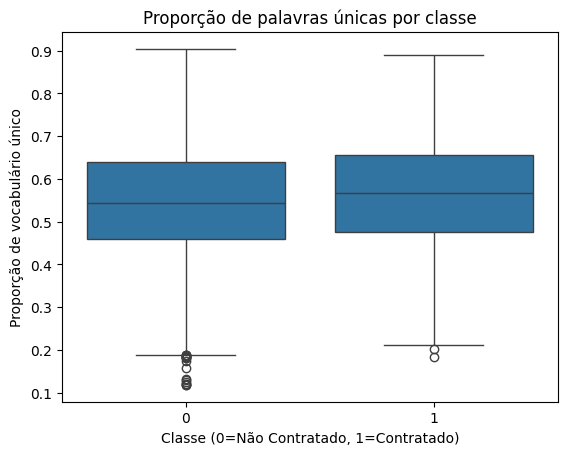

In [27]:
df_modelo['n_unicas'] = df_modelo['texto_completo_limpo'].apply(lambda x: len(set(x.split())))
df_modelo['prop_palavras_unicas'] = df_modelo['n_unicas'] / df_modelo['n_palavras']

# Boxplot comparativo
sns.boxplot(data=df_modelo, x='target_contratado', y='prop_palavras_unicas')
plt.title('Proporção de palavras únicas por classe')
plt.xlabel('Classe (0=Não Contratado, 1=Contratado)')
plt.ylabel('Proporção de vocabulário único')
plt.show()

## Extração tecnologias diretamente do texto

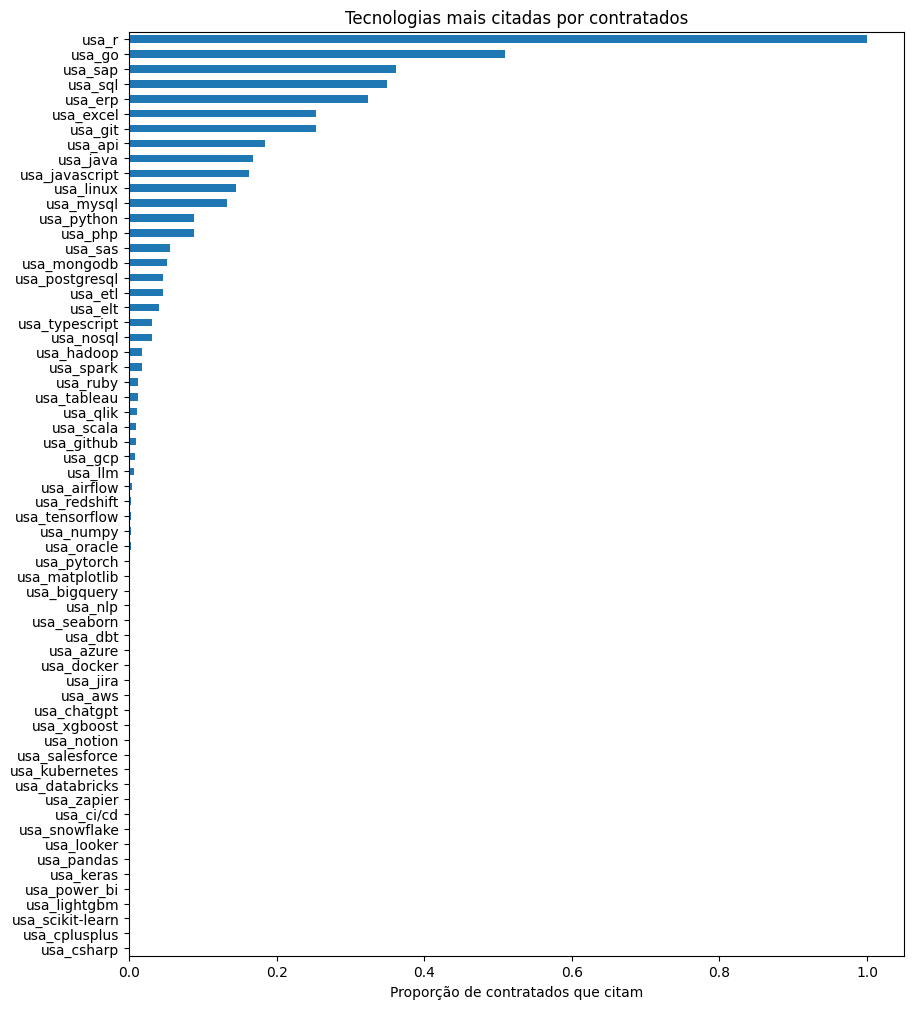

In [28]:
tecnologias = [
    # Linguagens de programação
    'python', 'java', 'javascript', 'typescript', 'c++', 'c#', 'r', 'go', 'ruby', 'php', 'scala',

    # SQL e bancos de dados
    'sql', 'mysql', 'postgresql', 'oracle', 'mongodb', 'nosql', 'redshift', 'bigquery',

    # Bibliotecas de dados / ML
    'pandas', 'numpy', 'scikit-learn', 'tensorflow', 'keras', 'pytorch', 'matplotlib', 'seaborn', 'xgboost', 'lightgbm',

    # BI e análise
    'power bi', 'tableau', 'qlik', 'excel', 'looker',

    # Cloud / DevOps
    'aws', 'gcp', 'azure', 'docker', 'kubernetes', 'linux', 'git', 'github', 'ci/cd',

    # Ferramentas e plataformas
    'snowflake', 'databricks', 'airflow', 'jira', 'notion', 'zapier',

    # Processamento de dados
    'hadoop', 'spark', 'dbt', 'etl', 'elt', 'api',

    # Outros
    'sas', 'sap', 'erp', 'salesforce', 'nlp', 'chatgpt', 'llm'
]

for tech in tecnologias:
    col = f'usa_{tech.replace(" ", "_").replace("#", "sharp").replace("+", "plus")}'
    df_modelo[col] = df_modelo['texto_completo_limpo'].apply(lambda x: int(tech in x.lower()))

colunas_tecnologia = [f'usa_{tech.replace(" ", "_").replace("#", "sharp").replace("+", "plus")}' for tech in tecnologias]
df_tecnologias = df_modelo[df_modelo['target_contratado'] == 1][colunas_tecnologia]
df_tecnologias.mean().sort_values(ascending=True).plot(kind='barh', figsize=(10, 12), title='Tecnologias mais citadas por contratados')
plt.xlabel('Proporção de contratados que citam')
plt.show()

## Ranking por tecnologia e por classe (target_contratado)

In [29]:
# Criar DataFrame com proporção de uso por classe
ranking_tecnologias = df_modelo.groupby('target_contratado')[
    [f'usa_{tech.replace(" ", "_").replace("#", "sharp").replace("+", "plus")}' for tech in tecnologias]
].mean().T

# Renomear colunas para legibilidade
ranking_tecnologias.columns = ['Não Contratado', 'Contratado']
# Adicionar coluna com diferença absoluta
ranking_tecnologias['dif_contratado'] = ranking_tecnologias['Contratado'] - ranking_tecnologias['Não Contratado']
# Mostrar ranking com maior presença entre contratados
ranking_tecnologias.sort_values(by='Contratado', ascending=False).head(20)

,Não Contratado,Contratado,dif_contratado
usa_r,1.000000,1.000000,0.000000
usa_go,0.615315,0.509548,-0.105767
usa_sap,0.450486,0.362144,-0.088342
usa_sql,0.451767,0.349079,-0.102688
usa_erp,0.412711,0.323283,-0.089428
usa_excel,0.293418,0.253936,-0.039482
usa_git,0.328199,0.253266,-0.074933
usa_api,0.287647,0.184925,-0.102723
usa_java,0.233033,0.168174,-0.064858
usa_javascript,0.226967,0.163149,-0.063817


In [33]:
grupo0 = df_modelo[df_modelo['target_contratado'] == 0]['pontuacao_tecnologica']
grupo1 = df_modelo[df_modelo['target_contratado'] == 1]['pontuacao_tecnologica']

t_stat, p_value = ttest_ind(grupo0, grupo1)
print(f"p-valor: {p_value}")


p-valor: 7.614291506633445e-40


In [41]:
# Separar os grupos
grupo0 = df_modelo[df_modelo['target_contratado'] == 0]['pct_tecnologias_avancadas']
grupo1 = df_modelo[df_modelo['target_contratado'] == 1]['pct_tecnologias_avancadas']

# 1. Teste de normalidade (Shapiro-Wilk)
stat0, p_shapiro0 = shapiro(grupo0.sample(500, random_state=42))  # amostra de até 500 por limitação do teste
stat1, p_shapiro1 = shapiro(grupo1.sample(500, random_state=42))

print(f"Shapiro - Grupo 0 (Não contratado): p-valor = {p_shapiro0:.4f}")
print(f"Shapiro - Grupo 1 (Contratado): p-valor = {p_shapiro1:.4f}")

# 2. Teste de homogeneidade de variância (Levene)
stat_lev, p_levene = levene(grupo0, grupo1)
print(f"Levene (homogeneidade de variância): p-valor = {p_levene:.4f}")

# 3. Escolha do teste
if p_shapiro0 > 0.05 and p_shapiro1 > 0.05:
    print("\nDistribuições normais — prosseguindo com teste t")
    t_stat, p_t = ttest_ind(grupo0, grupo1, equal_var=p_levene > 0.05)
    print(f"Teste t: p-valor = {p_t:.4e}")
else:
    print("\nDistribuições não normais — usando Mann-Whitney")
    u_stat, p_mw = mannwhitneyu(grupo0, grupo1, alternative='two-sided')
    print(f"Mann-Whitney: p-valor = {p_mw:.4e}")

Shapiro - Grupo 0 (Não contratado): p-valor = 0.0000
Shapiro - Grupo 1 (Contratado): p-valor = 0.0000
Levene (homogeneidade de variância): p-valor = 0.0000

Distribuições não normais — usando Mann-Whitney
Mann-Whitney: p-valor = 1.6048e-08
